# Urinary system diseases classification
#### Presumptive classification of nephritis from inflammation

This notebook aims to create a classification model for the dataset described in here https://www.kaggle.com/yamqwe/acute-inflammationse


```
Credit:
Jacek Czerniak, Ph.D., Assistant ProfessorSystems Research InstitutePolish Academy of SciencesLaboratory of Intelligent Systems ul. Newelska 6, Room 21801-447 Warszawa, Polande-mail:
jacek.czerniak '@' ibspan.waw.pl or jczerniak '@' ukw.edu.pl
```

In [1]:
import pandas as pd
import sagemaker
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()

## Feature engineering

### Load data

In [3]:
data_file = 'data/diagnosis.data'
columns = ['Temperature of patient', 'Occurrence of nausea', 'Lumbar pain', 'Urine pushing (continuous need for urination)', 'Micturition pains', 'Burning of urethra, itch, swelling of urethra outlet', 'Inflammation of urinary bladder', 'Nephritis of renal pelvis origin']
data_df = pd.read_csv(filepath_or_buffer=data_file, sep='\t', header=None, names=columns, encoding='utf-16')
data_df.head()

Temperature of patient Occurrence of nausea Lumbar pain  \
0                   35,5                   no         yes   
1                   35,9                   no          no   
2                   35,9                   no         yes   
3                   36,0                   no          no   
4                   36,0                   no         yes   

  Urine pushing (continuous need for urination) Micturition pains  \
0                                            no                no   
1                                           yes               yes   
2                                            no                no   
3                                           yes               yes   
4                                            no                no   

  Burning of urethra, itch, swelling of urethra outlet  \
0                                                 no     
1                                                yes     
2                                                 no     
3                                                yes     
4                                                 no     

  Inflammation of urinary bladder Nephritis of renal pelvis origin  
0                              no                               no  
1                             yes                               no  
2                              no                               no  
3                             yes                               no  
4                              no                               no

### Drop missing values

In [4]:
data_df.shape

(120, 8)

In [5]:
data_df = data_df.dropna(axis=0)
data_df.shape

(120, 8)

There are no missing values

### Convert text to numbers

In [6]:
for c in columns[1:]:
    data_df.loc[data_df[c]=='no',c] = 0
    data_df.loc[data_df[c]=='yes',c] = 1
data_df.head()

Temperature of patient Occurrence of nausea Lumbar pain  \
0                   35,5                    0           1   
1                   35,9                    0           0   
2                   35,9                    0           1   
3                   36,0                    0           0   
4                   36,0                    0           1   

  Urine pushing (continuous need for urination) Micturition pains  \
0                                             0                 0   
1                                             1                 1   
2                                             0                 0   
3                                             1                 1   
4                                             0                 0   

  Burning of urethra, itch, swelling of urethra outlet  \
0                                                  0     
1                                                  1     
2                                                  0     
3                                                  1     
4                                                  0     

  Inflammation of urinary bladder Nephritis of renal pelvis origin  
0                               0                                0  
1                               1                                0  
2                               0                                0  
3                               1                                0  
4                               0                                0

Convert temperature decimal character

In [7]:
data_df['Temperature of patient'] = data_df['Temperature of patient'].str.replace(',','.')
data_df.head()

Temperature of patient Occurrence of nausea Lumbar pain  \
0                   35.5                    0           1   
1                   35.9                    0           0   
2                   35.9                    0           1   
3                   36.0                    0           0   
4                   36.0                    0           1   

  Urine pushing (continuous need for urination) Micturition pains  \
0                                             0                 0   
1                                             1                 1   
2                                             0                 0   
3                                             1                 1   
4                                             0                 0   

  Burning of urethra, itch, swelling of urethra outlet  \
0                                                  0     
1                                                  1     
2                                                  0     
3                                                  1     
4                                                  0     

  Inflammation of urinary bladder Nephritis of renal pelvis origin  
0                               0                                0  
1                               1                                0  
2                               0                                0  
3                               1                                0  
4                               0                                0

In [9]:
data_df = data_df.astype({'Temperature of patient':'float',
        'Occurrence of nausea':'float',
        'Lumbar pain':'float',
        'Urine pushing (continuous need for urination)':'float',
        'Micturition pains':'float',
        'Burning of urethra, itch, swelling of urethra outlet':'float'
})
data_df.dtypes

Temperature of patient                                  float64
Occurrence of nausea                                    float64
Lumbar pain                                             float64
Urine pushing (continuous need for urination)           float64
Micturition pains                                       float64
Burning of urethra, itch, swelling of urethra outlet    float64
Inflammation of urinary bladder                          object
Nephritis of renal pelvis origin                         object
dtype: object

### Create labels  

- Check if one patient can have both diseases

In [11]:
data_df[(data_df['Inflammation of urinary bladder'] == 1) & (data_df['Nephritis of renal pelvis origin'] == 1)].shape

(19, 8)

- Check if one patient don't have any disease

In [12]:
data_df[(data_df['Inflammation of urinary bladder'] == 0) & (data_df['Nephritis of renal pelvis origin'] == 0)].shape

(30, 8)

Create a Diagnosis column which will serve as our label. It can have values of
- 0 : if patient has no disease
- 1 : if patient was diagnosed with just "Nephritis of renal pelvis origin"
- 2 : if patient was diagnosed with just "Inflammation of urinary bladder"
- 3 : if patient was diagnosed with both diseases

In [14]:
conditions = [
    ((data_df['Inflammation of urinary bladder'] ==
     0) & (data_df['Nephritis of renal pelvis origin'] == 0)),
    ((data_df['Inflammation of urinary bladder'] ==
     0) & (data_df['Nephritis of renal pelvis origin'] == 1)),
    ((data_df['Inflammation of urinary bladder'] ==
     1) & (data_df['Nephritis of renal pelvis origin'] == 0)),
    ((data_df['Inflammation of urinary bladder'] ==
     1) & (data_df['Nephritis of renal pelvis origin'] == 1))
]
values = [0, 1, 2, 3]
data_df['Diagnosis'] = np.select(conditions, values)
data_df.head()


Temperature of patient  Occurrence of nausea  Lumbar pain  \
0                    35.5                   0.0          1.0   
1                    35.9                   0.0          0.0   
2                    35.9                   0.0          1.0   
3                    36.0                   0.0          0.0   
4                    36.0                   0.0          1.0   

   Urine pushing (continuous need for urination)  Micturition pains  \
0                                            0.0                0.0   
1                                            1.0                1.0   
2                                            0.0                0.0   
3                                            1.0                1.0   
4                                            0.0                0.0   

   Burning of urethra, itch, swelling of urethra outlet  \
0                                                0.0      
1                                                1.0      
2                                                0.0      
3                                                1.0      
4                                                0.0      

  Inflammation of urinary bladder Nephritis of renal pelvis origin  Diagnosis  
0                               0                                0          0  
1                               1                                0          2  
2                               0                                0          0  
3                               1                                0          2  
4                               0                                0          0

### Drop previous diagnosis columns

In [15]:
data_df = data_df.drop(['Inflammation of urinary bladder', 'Nephritis of renal pelvis origin'], axis=1)
data_df.head()

Temperature of patient  Occurrence of nausea  Lumbar pain  \
0                    35.5                   0.0          1.0   
1                    35.9                   0.0          0.0   
2                    35.9                   0.0          1.0   
3                    36.0                   0.0          0.0   
4                    36.0                   0.0          1.0   

   Urine pushing (continuous need for urination)  Micturition pains  \
0                                            0.0                0.0   
1                                            1.0                1.0   
2                                            0.0                0.0   
3                                            1.0                1.0   
4                                            0.0                0.0   

   Burning of urethra, itch, swelling of urethra outlet  Diagnosis  
0                                                0.0             0  
1                                                1.0             2  
2                                                0.0             0  
3                                                1.0             2  
4                                                0.0             0

In [16]:
data_df = data_df.astype({'Diagnosis':'category'})
data_df.dtypes

Temperature of patient                                   float64
Occurrence of nausea                                     float64
Lumbar pain                                              float64
Urine pushing (continuous need for urination)            float64
Micturition pains                                        float64
Burning of urethra, itch, swelling of urethra outlet     float64
Diagnosis                                               category
dtype: object

### Data exploration

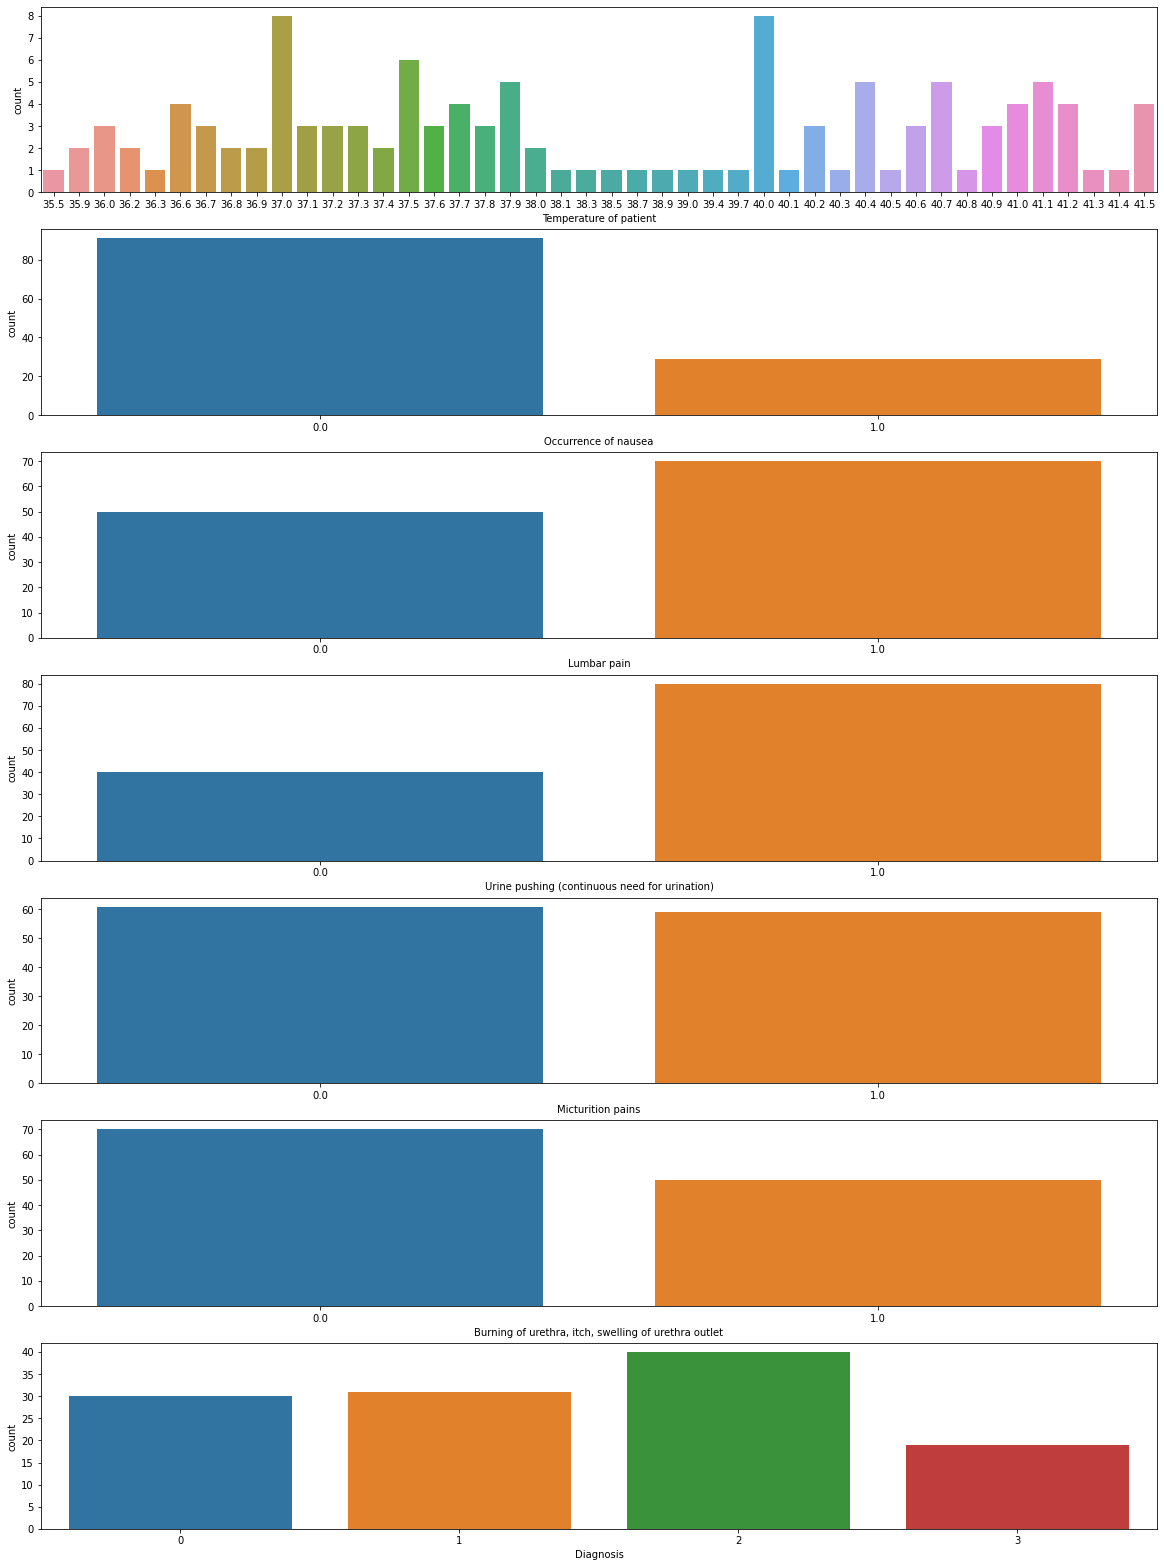

In [18]:
fig, ax =plt.subplots(len(data_df.columns),1, figsize=(20,4*len(data_df.columns)))
for i, c in enumerate(data_df.columns):
    sns.countplot(data=data_df, x=c, ax=ax[i])
fig.show()

There are more patients with temperatures less than 38 celcius (low fever), but the number of patients with more than 40 celcius (high fever) is almost the same. But we can see that there are distinct groups.
The most imbalanced input is Occurency of Nausea.

### Scale temperature

In [19]:
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
data_df[['Temperature of patient']]=pd.DataFrame(scaler.fit_transform(data_df[['Temperature of patient']].astype(float)))
data_df.head()

Temperature of patient  Occurrence of nausea  Lumbar pain  \
0                0.000000                   0.0          1.0   
1                0.066667                   0.0          0.0   
2                0.066667                   0.0          1.0   
3                0.083333                   0.0          0.0   
4                0.083333                   0.0          1.0   

   Urine pushing (continuous need for urination)  Micturition pains  \
0                                            0.0                0.0   
1                                            1.0                1.0   
2                                            0.0                0.0   
3                                            1.0                1.0   
4                                            0.0                0.0   

   Burning of urethra, itch, swelling of urethra outlet Diagnosis  
0                                                0.0            0  
1                                                1.0            2  
2                                                0.0            0  
3                                                1.0            2  
4                                                0.0            0

## One Hot Code the Diagnosis

We need to One Hot Code the Diagnosis because our model is going to do Multiple Classification, it will return 4 values that indicate the probability of one of the possible results.

- D0 = [0, 0, 0, 0] none of these diseases detected
- D1 = [0, 1, 0, 0] only Nephritis of renal pelvis origin
- D2 = [0, 0, 1, 0] only Inflammation of urinary bladder
- D3 = [0, 0, 0, 1] both diseases

In [20]:
def one_hot_diagnosis(df, d):
    conditions = [
        ((df['Diagnosis']==d)),
        ((df['Diagnosis']!=d)),
    ]
    values = [1, 0]
    df['D'+str(d)] = np.select(conditions, values)
    return df

In [21]:
data_df=one_hot_diagnosis(data_df, 0)
data_df=one_hot_diagnosis(data_df, 1)
data_df=one_hot_diagnosis(data_df, 2)
data_df=one_hot_diagnosis(data_df, 3)

In [40]:
data_df.dtypes

Temperature of patient                                   float64
Occurrence of nausea                                     float64
Lumbar pain                                              float64
Urine pushing (continuous need for urination)            float64
Micturition pains                                        float64
Burning of urethra, itch, swelling of urethra outlet     float64
Diagnosis                                               category
D0                                                         int64
D1                                                         int64
D2                                                         int64
D3                                                         int64
dtype: object

### Correlation matrix

<AxesSubplot:>

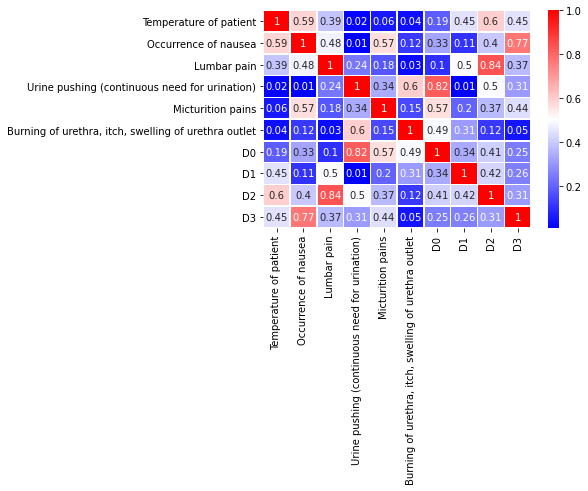

In [23]:
corr_matrix = data_df.corr().abs().round(2)
sns.heatmap(corr_matrix, annot=True, cmap='bwr', linewidths=.5)

D0 is much correlated with Urine pushing, this could mean the patient has some other disease. D1 (Nephritis) has some relation with Lumbar pain, but contrary to D2 (Inflammation) there is no Urine pushing. D2 is highly correlated to Lumbar pain. And D3 (both) has high occurency of nausea.

### Split train and test data

In [24]:
test_ratio = 0.2
test_index = int(data_df.shape[0]*(1-test_ratio))
train_df = data_df[:test_index]
test_df = data_df[test_index:]
train_X, train_Y = train_df[train_df.columns[:-5]], train_df[train_df.columns[-4:]]
test_X, test_Y = test_df[test_df.columns[:-5]], test_df[test_df.columns[-4:]]

### Save locally

In [25]:
data_dir = "urine-data"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
pd.concat([train_Y, train_X], axis=1).to_csv(os.path.join(data_dir, "train.csv"), header=False, index=False)
pd.concat([test_Y, test_X], axis=1).to_csv(os.path.join(data_dir, "test.csv"), header=False, index=False)

### Upload to S3

In [29]:
prefix = 'project-urine'

train_location = sagemaker_session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)
test_location = sagemaker_session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)

### Create AWS model

In [75]:
from sagemaker.pytorch import PyTorch

INPUT_DIM = train_X.shape[1]
HIDDEN_DIM = train_X.shape[1]*4
OUTPUT_DIM = train_Y.shape[1]

output_path = 's3://{}/{}'.format(bucket, prefix)
estimator = PyTorch(entry_point='train.py',
                    source_dir='source',
                    role=role,
                    framework_version='1.0',
                    py_version='py3',
                    train_instance_count=1,
                    train_instance_type='ml.c4.xlarge',
                    output_path=output_path,
                    sagemaker_session=sagemaker_session,
                    hyperparameters={
                        'input_features': INPUT_DIM,
                        'hidden_dim': HIDDEN_DIM,
                        'output_dim': OUTPUT_DIM,
                        'epochs': 100
                    })

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


### Train model in AWS

In [76]:
%%time

# Train your estimator on S3 training data
estimator.fit({'train': train_location})

2022-02-19 04:17:20 Starting - Starting the training job...ProfilerReport-1645244240: InProgress
...
2022-02-19 04:18:09 Starting - Preparing the instances for training...
2022-02-19 04:18:51 Downloading - Downloading input data.....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-02-19 04:19:29,581 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2022-02-19 04:19:29,584 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2022-02-19 04:19:29,604 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-02-19 04:19:29,604 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-02-19 04:19:29,965 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.py
2022-02-19 04:19:29,965 sagemaker-containers INFO     Generating setup.cfg
2022-02-19 04:19:29,965 sagemaker-conta

2
2
*******************
*******************
1.0.0
tensor([[0.2500, 0.2500, 0.2500, 0.2500]], grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[3]])
tensor([[0]])
3
0
*******************
*******************
1.0.0
tensor([[0.2500, 0.2500, 0.2500, 0.2500]], grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[3]])
tensor([[0]])
3
0
*******************
*******************
1.0.0
tensor([[0.1721, 0.1721, 0.4836, 0.1721]], grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[0.2500, 0.2500, 0.2500, 0.2500]], grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[3]])
tensor([[0]])
3
0
*******************
*******************
1.0.0
tensor([[0.1413, 0.1750, 0.5425, 0.1413]], grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[0.2207, 0.2207, 0.3380, 0.2207]], grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])


*******************
*******************
1.0.0
tensor([[0.2055, 0.2055, 0.3836, 0.2055]], grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[2]])
tensor([[0]])
2
0
*******************
*******************
1.0.0
tensor([[0.3233, 0.2350, 0.2209, 0.2209]], grad_fn=<ExpBackward>)
tensor([0., 1., 0., 0.])
tensor([[0]])
tensor([[1]])
0
1
*******************
*******************
1.0.0
tensor([[0.3510, 0.2163, 0.2163, 0.2163]], grad_fn=<ExpBackward>)
tensor([0., 1., 0., 0.])
tensor([[0]])
tensor([[1]])
0
1
*******************
*******************
1.0.0
tensor([[0.1426, 0.1426, 0.5721, 0.1426]], grad_fn=<ExpBackward>)
tensor([0., 1., 0., 0.])
tensor([[2]])
tensor([[1]])
2
1
*******************
*******************
1.0.0
tensor([[0.2630, 0.2457, 0.2457, 0.2457]], grad_fn=<ExpBackward>)
tensor([0., 0., 0., 1.])
tensor([[0]])
tensor([[3]])
0
3
*******************
*******************
1.0.0
tensor([[0.2500, 0.2500, 0.2500, 0.2500]], grad_fn=<ExpBackward>)
tensor([0., 0., 0., 1.])
tensor([[3]])
tens

tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[0.3778, 0.2185, 0.2018, 0.2018]], grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[0]])
tensor([[0]])
0
0
*******************
*******************
1.0.0
tensor([[0.0685, 0.0685, 0.7944, 0.0685]], grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[0.4140, 0.2105, 0.1877, 0.1877]], grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[0]])
tensor([[0]])
0
0
*******************
*******************
1.0.0
tensor([[0.0019, 0.0019, 0.9943, 0.0019]], grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[0.0251, 0.0251, 0.9246, 0.0251]], grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[9.2273e-04, 9.2273e-04, 9.9723e-01, 9.2273e

2
*******************
*******************
1.0.0
tensor([[0.0028, 0.0036, 0.9908, 0.0028]], grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[0.0029, 0.0047, 0.9895, 0.0029]], grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[2.7395e-06, 2.7395e-06, 9.9999e-01, 2.7395e-06]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[4.3449e-06, 4.3449e-06, 9.9999e-01, 4.3449e-06]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[0.6773, 0.1343, 0.0942, 0.0942]], grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[0]])
tensor([[0]])
0
0
*******************
*******************
1.0.0
tensor([[0.0110, 0.0110, 0.9669, 0.0110]], grad_fn=<ExpBackwa

*******************
1.0.0
tensor([[1.4366e-05, 1.4366e-05, 9.9996e-01, 1.4366e-05]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[0.0019, 0.0036, 0.9926, 0.0019]], grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[0.0034, 0.0034, 0.9897, 0.0034]], grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[2.8966e-04, 7.9027e-04, 9.9863e-01, 2.8966e-04]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[6.2868e-04, 1.1840e-03, 9.9756e-01, 6.2868e-04]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[3.7749e-04, 3.7749e-04, 9.9887e-01, 3.7749e-04]],
 

0
0
*******************
*******************
1.0.0
tensor([[9.4073e-05, 4.3672e-04, 9.9938e-01, 9.4073e-05]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[8.3554e-04, 8.3554e-04, 9.9749e-01, 8.3554e-04]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[0.4879, 0.3405, 0.0858, 0.0858]], grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[0]])
tensor([[0]])
0
0
*******************
*******************
1.0.0
tensor([[1.4152e-06, 1.4152e-06, 1.0000e+00, 1.4152e-06]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[8.8854e-07, 1.1974e-06, 1.0000e+00, 8.8854e-07]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[3.16

tensor([[0.2812, 0.5054, 0.1067, 0.1067]], grad_fn=<ExpBackward>)
tensor([0., 0., 0., 1.])
tensor([[1]])
tensor([[3]])
1
3
*******************
*******************
1.0.0
tensor([[0.0634, 0.6399, 0.2334, 0.0634]], grad_fn=<ExpBackward>)
tensor([0., 0., 0., 1.])
tensor([[1]])
tensor([[3]])
1
3
*******************
*******************
1.0.0
tensor([[0.3442, 0.2593, 0.1982, 0.1982]], grad_fn=<ExpBackward>)
tensor([0., 0., 0., 1.])
tensor([[0]])
tensor([[3]])
0
3
*******************
*******************
1.0.0
tensor([[0.5807, 0.1542, 0.1325, 0.1325]], grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[0]])
tensor([[0]])
0
0
*******************
*******************
1.0.0
tensor([[0.7103, 0.1439, 0.0729, 0.0729]], grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[0]])
tensor([[0]])
0
0
*******************
*******************
1.0.0
tensor([[0.1203, 0.7497, 0.0650, 0.0650]], grad_fn=<ExpBackward>)
tensor([0., 1., 0., 0.])
tensor([[1]])
tensor([[1]])
1
1
*******************
************

tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[0.0104, 0.0430, 0.9363, 0.0104]], grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[7.9741e-05, 8.9197e-05, 9.9975e-01, 7.9741e-05]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[2.0229e-06, 2.0229e-06, 9.9999e-01, 2.0229e-06]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[0.9678, 0.0230, 0.0046, 0.0046]], grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[0]])
tensor([[0]])
0
0
*******************
*******************
1.0.0
tensor([[8.9050e-05, 8.9050e-05, 9.9973e-01, 8.9050e-05]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[0.0183, 0.018

1.0.0
tensor([[0.6511, 0.2471, 0.0509, 0.0509]], grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[0]])
tensor([[0]])
0
0
*******************
*******************
1.0.0
tensor([[9.1318e-05, 4.4282e-03, 9.9539e-01, 9.1318e-05]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[0.9333, 0.0540, 0.0063, 0.0063]], grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[0]])
tensor([[0]])
0
0
*******************
*******************
1.0.0
tensor([[6.1386e-05, 3.0577e-04, 9.9957e-01, 6.1386e-05]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[1.3296e-04, 2.2846e-04, 9.9951e-01, 1.3296e-04]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[2.2492e-04, 2.2492e-04, 9.9933e-01, 2.2492e-04]],
       grad_fn=<ExpBa

1.0.0
tensor([[2.5096e-04, 5.5513e-03, 9.9395e-01, 2.5096e-04]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[2.3604e-04, 2.3604e-04, 9.9929e-01, 2.3604e-04]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[9.9727e-01, 1.3787e-03, 6.7485e-04, 6.7485e-04]],
       grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[0]])
tensor([[0]])
0
0
*******************
*******************
1.0.0
tensor([[4.4997e-08, 4.4997e-08, 1.0000e+00, 4.4997e-08]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[1.1891e-04, 7.8809e-04, 9.9897e-01, 1.1891e-04]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[3.5619e-04, 3.5619e-04, 9

*******************
*******************
1.0.0
tensor([[0.0922, 0.0774, 0.7530, 0.0774]], grad_fn=<ExpBackward>)
tensor([0., 0., 0., 1.])
tensor([[2]])
tensor([[3]])
2
3
*******************
*******************
1.0.0
tensor([[0.9800, 0.0126, 0.0037, 0.0037]], grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[0]])
tensor([[0]])
0
0
*******************
*******************
1.0.0
tensor([[0.6374, 0.2434, 0.0596, 0.0596]], grad_fn=<ExpBackward>)
tensor([0., 1., 0., 0.])
tensor([[0]])
tensor([[1]])
0
1
*******************
*******************
1.0.0
tensor([[0.4993, 0.4496, 0.0256, 0.0256]], grad_fn=<ExpBackward>)
tensor([0., 1., 0., 0.])
tensor([[0]])
tensor([[1]])
0
1
*******************
*******************
1.0.0
tensor([[0.0495, 0.8516, 0.0495, 0.0495]], grad_fn=<ExpBackward>)
tensor([0., 0., 0., 1.])
tensor([[1]])
tensor([[3]])
1
3
*******************
*******************
1.0.0
tensor([[0.5519, 0.1846, 0.1317, 0.1317]], grad_fn=<ExpBackward>)
tensor([0., 0., 0., 1.])
tensor([[0]])
tens

*******************
*******************
1.0.0
tensor([[0.7691, 0.1846, 0.0232, 0.0232]], grad_fn=<ExpBackward>)
tensor([0., 1., 0., 0.])
tensor([[0]])
tensor([[1]])
0
1
*******************
*******************
1.0.0
tensor([[0.0027, 0.9919, 0.0027, 0.0027]], grad_fn=<ExpBackward>)
tensor([0., 1., 0., 0.])
tensor([[1]])
tensor([[1]])
1
1
*******************
*******************
1.0.0
tensor([[0.2307, 0.5952, 0.0871, 0.0871]], grad_fn=<ExpBackward>)
tensor([0., 1., 0., 0.])
tensor([[1]])
tensor([[1]])
1
1
*******************
*******************
1.0.0
tensor([[0.1187, 0.8323, 0.0245, 0.0245]], grad_fn=<ExpBackward>)
tensor([0., 1., 0., 0.])
tensor([[1]])
tensor([[1]])
1
1
*******************
*******************
1.0.0
tensor([[0.0060, 0.9819, 0.0060, 0.0060]], grad_fn=<ExpBackward>)
tensor([0., 1., 0., 0.])
tensor([[1]])
tensor([[1]])
1
1
*******************
*******************
1.0.0
tensor([[0.0020, 0.9939, 0.0020, 0.0020]], grad_fn=<ExpBackward>)
tensor([0., 1., 0., 0.])
tensor([[1]])
tens

1
*******************
*******************
1.0.0
tensor([[0.0255, 0.9236, 0.0255, 0.0255]], grad_fn=<ExpBackward>)
tensor([0., 0., 0., 1.])
tensor([[1]])
tensor([[3]])
1
3
*******************
*******************
1.0.0
tensor([[0.1843, 0.4470, 0.1843, 0.1843]], grad_fn=<ExpBackward>)
tensor([0., 0., 0., 1.])
tensor([[1]])
tensor([[3]])
1
3
*******************
*******************
1.0.0
tensor([[0.9380, 0.0255, 0.0183, 0.0183]], grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[0]])
tensor([[0]])
0
0
*******************
*******************
1.0.0
tensor([[0.0157, 0.9751, 0.0046, 0.0046]], grad_fn=<ExpBackward>)
tensor([0., 1., 0., 0.])
tensor([[1]])
tensor([[1]])
1
1
*******************
*******************
1.0.0
tensor([[0.0042, 0.9856, 0.0060, 0.0042]], grad_fn=<ExpBackward>)
tensor([0., 0., 0., 1.])
tensor([[1]])
tensor([[3]])
1
3
*******************
*******************
1.0.0
tensor([[0.0058, 0.9825, 0.0058, 0.0058]], grad_fn=<ExpBackward>)
tensor([0., 0., 0., 1.])
tensor([[1]])
te

*******************
1.0.0
tensor([[6.1270e-05, 6.1270e-05, 9.9982e-01, 6.1270e-05]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[0.5068, 0.3104, 0.0914, 0.0914]], grad_fn=<ExpBackward>)
tensor([0., 1., 0., 0.])
tensor([[0]])
tensor([[1]])
0
1
*******************
*******************
1.0.0
tensor([[0.0073, 0.9671, 0.0182, 0.0073]], grad_fn=<ExpBackward>)
tensor([0., 1., 0., 0.])
tensor([[1]])
tensor([[1]])
1
1
*******************
*******************
1.0.0
tensor([[0.0796, 0.8085, 0.0559, 0.0559]], grad_fn=<ExpBackward>)
tensor([0., 1., 0., 0.])
tensor([[1]])
tensor([[1]])
1
1
*******************
*******************
1.0.0
tensor([[0.0846, 0.7461, 0.0846, 0.0846]], grad_fn=<ExpBackward>)
tensor([0., 1., 0., 0.])
tensor([[1]])
tensor([[1]])
1
1
*******************
*******************
1.0.0
tensor([[0.0091, 0.9726, 0.0091, 0.0091]], grad_fn=<ExpBackward>)
tensor([0., 1., 0., 0.])
tensor([[1]])
t

2
*******************
*******************
1.0.0
tensor([[0.9584, 0.0323, 0.0047, 0.0047]], grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[0]])
tensor([[0]])
0
0
*******************
*******************
1.0.0
tensor([[2.0091e-04, 2.0091e-04, 9.9940e-01, 2.0091e-04]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[4.6025e-05, 3.3840e-04, 9.9957e-01, 4.6025e-05]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[0.0025, 0.0045, 0.9905, 0.0025]], grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[9.9986e-01, 6.7042e-05, 3.7774e-05, 3.7774e-05]],
       grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[0]])
tensor([[0]])
0
0
*******************
*******************
1.0.0
tensor([[9.8977e-01, 9.8797e-03, 1.747

2
2
*******************
*******************
1.0.0
tensor([[9.9782e-01, 1.7556e-03, 2.1112e-04, 2.1112e-04]],
       grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[0]])
tensor([[0]])
0
0
*******************
*******************
1.0.0
tensor([[2.5107e-04, 4.4404e-04, 9.9905e-01, 2.5107e-04]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[2.6091e-05, 2.6091e-05, 9.9992e-01, 2.6091e-05]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[0.0034, 0.0034, 0.9899, 0.0034]], grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[1.6089e-07, 1.6089e-07, 1.0000e+00, 1.6089e-07]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[9.99

*******************
1.0.0
tensor([[9.5999e-05, 4.3540e-04, 9.9937e-01, 9.5999e-05]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[1.0087e-04, 1.8537e-04, 9.9961e-01, 1.0087e-04]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[9.9937e-01, 5.0954e-04, 5.9911e-05, 5.9911e-05]],
       grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[0]])
tensor([[0]])
0
0
*******************
*******************
1.0.0
tensor([[1.8235e-06, 1.8235e-06, 9.9999e-01, 1.8235e-06]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[6.3106e-10, 6.3106e-10, 1.0000e+00, 6.3106e-10]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[9.979

2
2
*******************
*******************
1.0.0
tensor([[6.9674e-09, 6.9674e-09, 1.0000e+00, 6.9674e-09]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[9.9984e-01, 7.2226e-05, 4.4314e-05, 4.4314e-05]],
       grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[0]])
tensor([[0]])
0
0
*******************
*******************
1.0.0
tensor([[0.0013, 0.0013, 0.9960, 0.0013]], grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[9.9992e-01, 7.5443e-05, 3.0911e-06, 3.0911e-06]],
       grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[0]])
tensor([[0]])
0
0
*******************
*******************
1.0.0
tensor([[2.9096e-07, 2.9096e-07, 1.0000e+00, 2.9096e-07]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[0.04


2022-02-19 04:19:49 Training - Training image download completed. Training in progress.2
*******************
*******************
1.0.0
tensor([[1.9639e-07, 1.9639e-07, 1.0000e+00, 1.9639e-07]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[0.0060, 0.0060, 0.9820, 0.0060]], grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[9.9795e-01, 8.9367e-04, 5.7986e-04, 5.7986e-04]],
       grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[0]])
tensor([[0]])
0
0
*******************
*******************
1.0.0
tensor([[1.5224e-04, 1.5224e-04, 9.9954e-01, 1.5224e-04]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[9.0191e-04, 9.0191e-04, 9.9729e-01, 9.0191e-04]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tenso

tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[9.9991e-01, 8.3023e-05, 2.3366e-06, 2.3366e-06]],
       grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[0]])
tensor([[0]])
0
0
*******************
*******************
1.0.0
tensor([[9.9992e-01, 6.1204e-05, 7.4402e-06, 7.4402e-06]],
       grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[0]])
tensor([[0]])
0
0
*******************
*******************
1.0.0
tensor([[7.6299e-07, 7.6299e-07, 1.0000e+00, 7.6299e-07]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[9.9695e-01, 2.3239e-03, 3.6269e-04, 3.6269e-04]],
       grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[0]])
tensor([[0]])
0
0
*******************
*******************
1.0.0
tensor([[9.9977e-01, 1.8611e-04, 2.4140e-05, 2.4140e-05]],
       grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[0]])
t

*******************
Epoch: 52  Train Loss: 0.87
*******************
1.0.0
tensor([[0.9747, 0.0176, 0.0038, 0.0038]], grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[0]])
tensor([[0]])
0
0
*******************
*******************
1.0.0
tensor([[0.0015, 0.0052, 0.9917, 0.0015]], grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[0.8492, 0.1446, 0.0031, 0.0031]], grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[0]])
tensor([[0]])
0
0
*******************
*******************
1.0.0
tensor([[1.0345e-06, 1.0345e-06, 1.0000e+00, 1.0345e-06]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[9.9797e-01, 1.5181e-03, 2.5362e-04, 2.5362e-04]],
       grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[0]])
tensor([[0]])
0
0
*******************
*******************
1.0.0
tensor([[9.9996e-01, 3.4842e-05, 8.

*******************
*******************
1.0.0
tensor([[0.0388, 0.8837, 0.0388, 0.0388]], grad_fn=<ExpBackward>)
tensor([0., 1., 0., 0.])
tensor([[1]])
tensor([[1]])
1
1
*******************
Epoch: 55  Train Loss: 0.87
*******************
1.0.0
tensor([[0.9858, 0.0119, 0.0011, 0.0011]], grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[0]])
tensor([[0]])
0
0
*******************
*******************
1.0.0
tensor([[2.2751e-04, 2.2751e-04, 9.9932e-01, 2.2751e-04]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[9.9717e-01, 1.7375e-03, 5.4615e-04, 5.4615e-04]],
       grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[0]])
tensor([[0]])
0
0
*******************
*******************
1.0.0
tensor([[1.0196e-08, 1.0196e-08, 1.0000e+00, 1.0196e-08]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[0.9

0
0
*******************
*******************
1.0.0
tensor([[0.0071, 0.0071, 0.9788, 0.0071]], grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[0.9666, 0.0300, 0.0017, 0.0017]], grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[0]])
tensor([[0]])
0
0
*******************
*******************
1.0.0
tensor([[2.4362e-06, 2.4362e-06, 9.9999e-01, 2.4362e-06]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[3.9901e-04, 3.9901e-04, 9.9880e-01, 3.9901e-04]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[4.1885e-06, 4.1885e-06, 9.9999e-01, 4.1885e-06]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[1.2204e-06, 1.2204e-06, 1.0

*******************
1.0.0
tensor([[0.1372, 0.8199, 0.0215, 0.0215]], grad_fn=<ExpBackward>)
tensor([0., 1., 0., 0.])
tensor([[1]])
tensor([[1]])
1
1
*******************
*******************
1.0.0
tensor([[0.0020, 0.9939, 0.0020, 0.0020]], grad_fn=<ExpBackward>)
tensor([0., 1., 0., 0.])
tensor([[1]])
tensor([[1]])
1
1
*******************
*******************
1.0.0
tensor([[0.0239, 0.9542, 0.0109, 0.0109]], grad_fn=<ExpBackward>)
tensor([0., 1., 0., 0.])
tensor([[1]])
tensor([[1]])
1
1
*******************
*******************
1.0.0
tensor([[0.0053, 0.9841, 0.0053, 0.0053]], grad_fn=<ExpBackward>)
tensor([0., 1., 0., 0.])
tensor([[1]])
tensor([[1]])
1
1
*******************
*******************
1.0.0
tensor([[0.0022, 0.9935, 0.0022, 0.0022]], grad_fn=<ExpBackward>)
tensor([0., 1., 0., 0.])
tensor([[1]])
tensor([[1]])
1
1
*******************
*******************
1.0.0
tensor([[1.0989e-04, 9.9967e-01, 1.0989e-04, 1.0989e-04]],
       grad_fn=<ExpBackward>)
tensor([0., 1., 0., 0.])
tensor([[1]])
t

*******************
1.0.0
tensor([[9.9998e-01, 1.2603e-05, 4.9678e-06, 4.9678e-06]],
       grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[0]])
tensor([[0]])
0
0
*******************
*******************
1.0.0
tensor([[4.4678e-08, 4.4678e-08, 1.0000e+00, 4.4678e-08]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[4.8374e-04, 6.4493e-05, 9.9939e-01, 6.4493e-05]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[1.1648e-04, 1.1648e-04, 9.9965e-01, 1.1648e-04]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[5.4305e-06, 5.4305e-06, 9.9998e-01, 5.4305e-06]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[9.999

*******************
*******************
1.0.0
tensor([[0.9931, 0.0035, 0.0017, 0.0017]], grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[0]])
tensor([[0]])
0
0
*******************
*******************
1.0.0
tensor([[0.5253, 0.3448, 0.0650, 0.0650]], grad_fn=<ExpBackward>)
tensor([0., 1., 0., 0.])
tensor([[0]])
tensor([[1]])
0
1
*******************
*******************
1.0.0
tensor([[0.0307, 0.9024, 0.0363, 0.0307]], grad_fn=<ExpBackward>)
tensor([0., 1., 0., 0.])
tensor([[1]])
tensor([[1]])
1
1
*******************
*******************
1.0.0
tensor([[0.4531, 0.1784, 0.1900, 0.1784]], grad_fn=<ExpBackward>)
tensor([0., 0., 0., 1.])
tensor([[0]])
tensor([[3]])
0
3
*******************
*******************
1.0.0
tensor([[0.2133, 0.3600, 0.2133, 0.2133]], grad_fn=<ExpBackward>)
tensor([0., 0., 0., 1.])
tensor([[1]])
tensor([[3]])
1
3
*******************
*******************
1.0.0
tensor([[0.2080, 0.3761, 0.2080, 0.2080]], grad_fn=<ExpBackward>)
tensor([0., 0., 0., 1.])
tensor([[1]])
tens

3
3
*******************
*******************
1.0.0
tensor([[9.9995e-01, 3.9868e-05, 4.8052e-06, 4.8052e-06]],
       grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[0]])
tensor([[0]])
0
0
*******************
*******************
1.0.0
tensor([[9.9984e-01, 1.1883e-04, 2.0741e-05, 2.0741e-05]],
       grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[0]])
tensor([[0]])
0
0
*******************
*******************
1.0.0
tensor([[0.0596, 0.8213, 0.0596, 0.0596]], grad_fn=<ExpBackward>)
tensor([0., 1., 0., 0.])
tensor([[1]])
tensor([[1]])
1
1
*******************
*******************
1.0.0
tensor([[0.0118, 0.9645, 0.0118, 0.0118]], grad_fn=<ExpBackward>)
tensor([0., 1., 0., 0.])
tensor([[1]])
tensor([[1]])
1
1
*******************
*******************
1.0.0
tensor([[0.1143, 0.8202, 0.0327, 0.0327]], grad_fn=<ExpBackward>)
tensor([0., 1., 0., 0.])
tensor([[1]])
tensor([[1]])
1
1
*******************
*******************
1.0.0
tensor([[0.2013, 0.3962, 0.2013, 0.2013]], grad_fn=<ExpBack

tensor([[3.3008e-05, 3.3008e-05, 9.9990e-01, 3.3008e-05]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[9.9999e-01, 9.5131e-06, 2.2173e-07, 2.2173e-07]],
       grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[0]])
tensor([[0]])
0
0
*******************
*******************
1.0.0
tensor([[8.9314e-07, 8.9314e-07, 1.0000e+00, 8.9314e-07]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[3.0147e-06, 3.0147e-06, 9.9999e-01, 3.0147e-06]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[3.5630e-05, 3.5630e-05, 9.9989e-01, 3.5630e-05]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[1.0000e+00, 6.1566e-09, 3.4874e

tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[9.9904e-01, 7.5334e-04, 1.0117e-04, 1.0117e-04]],
       grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[0]])
tensor([[0]])
0
0
*******************
*******************
1.0.0
tensor([[2.3987e-05, 2.3987e-05, 9.9993e-01, 2.3987e-05]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[1.4882e-09, 1.4882e-09, 1.0000e+00, 1.4882e-09]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[0.0011, 0.0011, 0.9967, 0.0011]], grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[1.8278e-05, 1.8278e-05, 9.9995e-01, 1.8278e-05]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
***********

*******************
*******************
1.0.0
tensor([[0.9896, 0.0058, 0.0023, 0.0023]], grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[0]])
tensor([[0]])
0
0
*******************
*******************
1.0.0
tensor([[9.9746e-01, 2.4318e-03, 5.6572e-05, 5.6572e-05]],
       grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[0]])
tensor([[0]])
0
0
*******************
*******************
1.0.0
tensor([[5.1281e-04, 5.1281e-04, 9.9846e-01, 5.1281e-04]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[0.9828, 0.0132, 0.0020, 0.0020]], grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[0]])
tensor([[0]])
0
0
*******************
*******************
1.0.0
tensor([[9.6504e-01, 3.4448e-02, 2.5718e-04, 2.5718e-04]],
       grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[0]])
tensor([[0]])
0
0
*******************
*******************
1.0.0
tensor([[4.9331e-10, 4.9331e-10, 1.0000e

tensor([[0.0015, 0.9955, 0.0015, 0.0015]], grad_fn=<ExpBackward>)
tensor([0., 1., 0., 0.])
tensor([[1]])
tensor([[1]])
1
1
*******************
*******************
1.0.0
tensor([[5.4098e-04, 9.9838e-01, 5.4098e-04, 5.4098e-04]],
       grad_fn=<ExpBackward>)
tensor([0., 1., 0., 0.])
tensor([[1]])
tensor([[1]])
1
1
*******************
*******************
1.0.0
tensor([[4.4894e-04, 9.9865e-01, 4.4894e-04, 4.4894e-04]],
       grad_fn=<ExpBackward>)
tensor([0., 1., 0., 0.])
tensor([[1]])
tensor([[1]])
1
1
*******************
*******************
1.0.0
tensor([[2.9451e-05, 9.9991e-01, 2.9451e-05, 2.9451e-05]],
       grad_fn=<ExpBackward>)
tensor([0., 1., 0., 0.])
tensor([[1]])
tensor([[1]])
1
1
*******************
*******************
1.0.0
tensor([[4.2897e-04, 9.9719e-01, 1.9500e-03, 4.2897e-04]],
       grad_fn=<ExpBackward>)
tensor([0., 1., 0., 0.])
tensor([[1]])
tensor([[1]])
1
1
*******************
*******************
1.0.0
tensor([[2.2224e-05, 9.9993e-01, 2.2224e-05, 2.2224e-05]],
    

1
*******************
*******************
1.0.0
tensor([[0.0101, 0.9698, 0.0101, 0.0101]], grad_fn=<ExpBackward>)
tensor([0., 1., 0., 0.])
tensor([[1]])
tensor([[1]])
1
1
*******************
*******************
1.0.0
tensor([[0.0113, 0.9847, 0.0020, 0.0020]], grad_fn=<ExpBackward>)
tensor([0., 1., 0., 0.])
tensor([[1]])
tensor([[1]])
1
1
*******************
*******************
1.0.0
tensor([[0.0246, 0.9380, 0.0187, 0.0187]], grad_fn=<ExpBackward>)
tensor([0., 1., 0., 0.])
tensor([[1]])
tensor([[1]])
1
1
*******************
*******************
1.0.0
tensor([[0.0205, 0.9470, 0.0163, 0.0163]], grad_fn=<ExpBackward>)
tensor([0., 1., 0., 0.])
tensor([[1]])
tensor([[1]])
1
1
*******************
*******************
1.0.0
tensor([[9.6116e-05, 9.9971e-01, 9.6116e-05, 9.6116e-05]],
       grad_fn=<ExpBackward>)
tensor([0., 1., 0., 0.])
tensor([[1]])
tensor([[1]])
1
1
*******************
*******************
1.0.0
tensor([[0.0294, 0.9685, 0.0011, 0.0011]], grad_fn=<ExpBackward>)
tensor([0., 1., 0.

2
2
*******************
*******************
1.0.0
tensor([[9.9998e-01, 5.4922e-06, 5.4922e-06, 5.4922e-06]],
       grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[0]])
tensor([[0]])
0
0
*******************
*******************
1.0.0
tensor([[9.1814e-08, 9.1814e-08, 1.0000e+00, 9.1814e-08]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[0.0032, 0.0032, 0.9903, 0.0032]], grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[3.3236e-07, 3.3236e-07, 1.0000e+00, 3.3236e-07]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[7.9995e-07, 7.9995e-07, 1.0000e+00, 7.9995e-07]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[1.00

tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[0.9856, 0.0101, 0.0022, 0.0022]], grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[0]])
tensor([[0]])
0
0
*******************
*******************
1.0.0
tensor([[2.2268e-08, 2.2268e-08, 1.0000e+00, 2.2268e-08]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[3.5559e-09, 3.5559e-09, 1.0000e+00, 3.5559e-09]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[1.0000e+00, 5.6719e-08, 5.6719e-08, 5.6719e-08]],
       grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[0]])
tensor([[0]])
0
0
*******************
*******************
1.0.0
tensor([[1.4353e-08, 1.4353e-08, 1.0000e+00, 1.4353e-08]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0

1
1
*******************
*******************
1.0.0
tensor([[0.0081, 0.9756, 0.0081, 0.0081]], grad_fn=<ExpBackward>)
tensor([0., 1., 0., 0.])
tensor([[1]])
tensor([[1]])
1
1
*******************
*******************
1.0.0
tensor([[0.2500, 0.2500, 0.2500, 0.2500]], grad_fn=<ExpBackward>)
tensor([0., 0., 0., 1.])
tensor([[3]])
tensor([[3]])
3
3
*******************
*******************
1.0.0
tensor([[0.2500, 0.2500, 0.2500, 0.2500]], grad_fn=<ExpBackward>)
tensor([0., 0., 0., 1.])
tensor([[3]])
tensor([[3]])
3
3
*******************
*******************
1.0.0
tensor([[0.2500, 0.2500, 0.2500, 0.2500]], grad_fn=<ExpBackward>)
tensor([0., 0., 0., 1.])
tensor([[3]])
tensor([[3]])
3
3
*******************
*******************
1.0.0
tensor([[9.9985e-01, 6.8462e-05, 3.9761e-05, 3.9761e-05]],
       grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[0]])
tensor([[0]])
0
0
*******************
*******************
1.0.0
tensor([[0.0124, 0.9627, 0.0124, 0.0124]], grad_fn=<ExpBackward>)
tensor([0., 1., 

       grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[0]])
tensor([[0]])
0
0
*******************
*******************
1.0.0
tensor([[1.5628e-07, 1.5628e-07, 1.0000e+00, 1.5628e-07]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[7.6945e-06, 7.6945e-06, 9.9998e-01, 7.6945e-06]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[1.0494e-05, 1.0494e-05, 9.9997e-01, 1.0494e-05]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[1.0000e+00, 1.9845e-06, 1.3378e-06, 1.3378e-06]],
       grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[0]])
tensor([[0]])
0
0
*******************
*******************
1.0.0
tensor([[0.0199, 0.0199, 0.9402, 0.0199]], grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([

*******************
*******************
1.0.0
tensor([[5.5659e-10, 5.5659e-10, 1.0000e+00, 5.5659e-10]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[9.9998e-01, 1.8994e-05, 5.4139e-07, 5.4139e-07]],
       grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[0]])
tensor([[0]])
0
0
*******************
*******************
1.0.0
tensor([[9.9932e-01, 6.3494e-04, 2.3895e-05, 2.3895e-05]],
       grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[0]])
tensor([[0]])
0
0
*******************
*******************
1.0.0
tensor([[4.4301e-14, 4.4301e-14, 1.0000e+00, 4.4301e-14]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[2.4083e-10, 2.4083e-10, 1.0000e+00, 2.4083e-10]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************


tensor([[0]])
0
0
*******************
*******************
1.0.0
tensor([[7.3341e-10, 7.3341e-10, 1.0000e+00, 7.3341e-10]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[9.9998e-01, 1.2048e-05, 6.6126e-06, 6.6126e-06]],
       grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[0]])
tensor([[0]])
0
0
*******************
*******************
1.0.0
tensor([[6.7918e-06, 6.7918e-06, 9.9998e-01, 6.7918e-06]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[4.6058e-06, 4.6058e-06, 9.9999e-01, 4.6058e-06]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[1.0000e+00, 4.8619e-09, 5.7428e-11, 5.7428e-11]],
       grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[0]])
tensor([[0]])
0
0
*******************
**

*******************
1.0.0
tensor([[1.0000e+00, 6.9786e-07, 6.9786e-07, 6.9786e-07]],
       grad_fn=<ExpBackward>)
tensor([1., 0., 0., 0.])
tensor([[0]])
tensor([[0]])
0
0
*******************
*******************
1.0.0
tensor([[1.6688e-09, 1.6688e-09, 1.0000e+00, 1.6688e-09]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[2.2037e-09, 2.2037e-09, 1.0000e+00, 2.2037e-09]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[9.7500e-08, 9.7500e-08, 1.0000e+00, 9.7500e-08]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[2.9081e-08, 2.9081e-08, 1.0000e+00, 2.9081e-08]],
       grad_fn=<ExpBackward>)
tensor([0., 0., 1., 0.])
tensor([[2]])
tensor([[2]])
2
2
*******************
*******************
1.0.0
tensor([[2.211


2022-02-19 04:20:30 Uploading - Uploading generated training model
2022-02-19 04:20:30 Completed - Training job completed
Training seconds: 82
Billable seconds: 82
CPU times: user 10.8 s, sys: 1.98 s, total: 12.8 s
Wall time: 3min 23s


### Deploy trained model

In [125]:
%%time

# uncomment, if needed
from sagemaker.pytorch import PyTorchModel
model = PyTorchModel(model_data=estimator.model_data,
                     role = role,
                     framework_version='1.0',
                     py_version='py3',
                     entry_point='predict.py',
                     source_dir='source')

# deploy your model to create a predictor
predictor = model.deploy(initial_instance_count=1, instance_type='ml.t2.medium')


-----!CPU times: user 472 ms, sys: 12.2 ms, total: 484 ms
Wall time: 2min 32s


### Evaluate

#### Rescale Temperature
Our predictor expects original temperature values (between 35.5 and 41.5)

In [84]:
input_test = test_X.copy()

In [85]:
input_test['Temperature of patient']=input_test['Temperature of patient']*(41.5-35.5)+35.5
input_test

Temperature of patient  Occurrence of nausea  Lumbar pain  \
96                     40.7                   0.0          1.0   
97                     40.8                   0.0          1.0   
98                     40.9                   1.0          1.0   
99                     40.9                   1.0          1.0   
100                    40.9                   0.0          1.0   
101                    41.0                   1.0          1.0   
102                    41.0                   0.0          0.0   
103                    41.0                   1.0          1.0   
104                    41.0                   0.0          1.0   
105                    41.1                   1.0          1.0   
106                    41.1                   1.0          1.0   
107                    41.1                   0.0          0.0   
108                    41.1                   1.0          1.0   
109                    41.1                   0.0          1.0   
110                    41.2                   1.0          1.0   
111                    41.2                   0.0          0.0   
112                    41.2                   1.0          1.0   
113                    41.2                   0.0          1.0   
114                    41.3                   1.0          1.0   
115                    41.4                   0.0          1.0   
116                    41.5                   0.0          0.0   
117                    41.5                   1.0          1.0   
118                    41.5                   0.0          1.0   
119                    41.5                   0.0          1.0   

     Urine pushing (continuous need for urination)  Micturition pains  \
96                                             1.0                0.0   
97                                             1.0                0.0   
98                                             1.0                1.0   
99                                             1.0                1.0   
100                                            1.0                0.0   
101                                            1.0                1.0   
102                                            0.0                0.0   
103                                            0.0                1.0   
104                                            1.0                0.0   
105                                            1.0                1.0   
106                                            1.0                1.0   
107                                            0.0                0.0   
108                                            0.0                1.0   
109                                            1.0                0.0   
110                                            1.0                1.0   
111                                            0.0                0.0   
112                                            0.0                1.0   
113                                            1.0                0.0   
114                                            1.0                1.0   
115                                            1.0                0.0   
116                                            0.0                0.0   
117                                            0.0                1.0   
118                                            1.0                0.0   
119                                            1.0                0.0   

     Burning of urethra, itch, swelling of urethra outlet  
96                                                 1.0     
97                                                 1.0     
98                                                 0.0     
99                                                 0.0     
100                                                1.0     
101                                                1.0     
102                                                0.0     
103                                             

In [126]:
results_test = predictor.predict(input_test.values).argmax(axis=1).reshape(-1, 1)
results_test

array([[1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1]])

In [112]:
test_labels = test_Y.values.argmax(axis=1).reshape(-1,1)
test_labels

array([[1],
       [1],
       [3],
       [3],
       [1],
       [3],
       [0],
       [1],
       [1],
       [3],
       [3],
       [0],
       [1],
       [1],
       [3],
       [0],
       [1],
       [1],
       [3],
       [1],
       [0],
       [1],
       [1],
       [1]])

In [127]:
correct = np.equal(test_labels, results_test).sum()
accuracy = correct/test_labels.shape[0]

print(accuracy)

0.7083333333333334
